<table class="ee-notebook-buttons" align="left">
    <td><a target="_blank"  href="https://github.com/NINAnor/urban-treeDetection"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" style="filter: invert(100%)"/> View source on GitHub</a></td>
    <td><a target="_blank"  href="https://drive.google.com/drive/folders/1mEQBfa-tVViVWFt27XzUP4Wr19u1iuZm"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run in Google Colab</a></td>
</table>

# Tree Crown Project | Extrapolating Ecosystem Service Values

**Author:** Willeke A'Campo

**Description:** 

This notebook shows the statistical results of extrapolating the regulating ecosystem service values of trees in the Oslo municipality using a Random Forest regression model. The model is trained on the i-Tree Eco trees within Oslo's urban tree database (registerte_traer_BYM_2018) and thereafter used to predict the regulating ecosystem service values for all trees within Oslo's building zone extent.

The following regulating ecosystem services are predicted: 

- carbon storage (kg)
- carbon sequestration (kg/year)
- avoided runoff (m3/year)
- avoided air pollution (g/year)
- total regulating ecosystem benefits (NKr/year)

The predictor variables used in the model are:
- tree species (Norwegian name)
- tree height (m)
- crown area (m2)
- pollution zone (zone 1, 2 or 3)

The results are visualized in a map product, which can be viewed online: [Bytræratlas Oslo](https://experience.arcgis.com/experience/5191adc2c4b34658aea227c9853c6ebb)

In [8]:
# import py-packages
import os
import logging
import seaborn as sns
import matplotlib.pyplot as plt

# import local packages
from src.config.config import load_catalog, load_parameters
from src.extrapolate_data import *
from src.config import logger

# configure logger
logger.setup_logging()
logger = logging.getLogger(__name__)
parameters = load_parameters()

# configure seaborn plot
sns.set_theme(
    context="notebook",  # paper, notebook, talk, and poster
    style="darkgrid",  # darkgrid, whitegrid, dark, white, and ticks
    palette="dark",  # deep, muted, bright, pastel, dark, and colorblind
    font="sans-serif",  # font family: serif, sans-serif, cursive, fantasy, and monospace
    font_scale=1,  # 1 = default font size (12pt)
    color_codes=True,  # False = don't color code from current palette
    rc=None,  # dict for additional settings (e.g. axes.labelsize=15)
)

2023-12-17 20:57:30 root [INFO]: Logging configuration file found and loaded.


In [2]:
df_ref, df_target = prepare_data()


2023-12-17 20:55:50 src.extrapolation.clean_reference [INFO]: Load reference data for municipality: kristiansand
2023-12-17 20:55:50 src.extrapolation.clean_reference [INFO]: Reference data shape: (80, 39)
2023-12-17 20:55:50 src.extrapolation.clean_reference [INFO]: Reference data columns: ['tree_id', 'itree_spec', 'area_code', 'district_code', 'norwegian_name', 'scientific_name', 'species_origin', 'dbh', 'dbh_origin', 'height_total_tree', 'height_origin', 'crown_area', 'crown_diam', 'crown_origin', 'pollution_zone', 'co2_storage_kg', 'co2_seq_kg_yr', 'runoff_m3', 'pollution_no2', 'pollution_pm25', 'pollution_so2', 'pollution_g', 'totben_cap', 'totben_cap_ca', 'SP_alm', 'SP_bjørk', 'SP_blodbøk', 'SP_bøk', 'SP_hestekastanje', 'SP_kulelønn', 'SP_lind', 'SP_lind_ssp', 'SP_neverhegg', 'SP_neverhegg?', 'SP_rosehagtorn', 'SP_småbladlind', 'SP_spisslønn', 'SP_svenskeasal', 'SP_søylekirsebær']
2023-12-17 20:55:50 src.extrapolation.clean_reference [INFO]: Reference data head:    tree_id  itree

In [10]:
display(df_ref.head())

,tree_id,itree_spec,area_code,district_code,norwegian_name,scientific_name,species_origin,dbh,dbh_origin,height_total_tree,...,SP_kulelønn,SP_lind,SP_lind_ssp,SP_neverhegg,SP_neverhegg?,SP_rosehagtorn,SP_småbladlind,SP_spisslønn,SP_svenskeasal,SP_søylekirsebær
0,itree_1,1,420408,42040804,søylekirsebær,Prunus serrulata ‘Amanogawa’,feltregistrering,7.96,feltregistrering,5.0,...,0,0,0,0,0,0,0,0,0,1
1,itree_2,1,420408,42040804,søylekirsebær,Prunus serrulata ‘Amanogawa’,feltregistrering,12.73,feltregistrering,5.0,...,0,0,0,0,0,0,0,0,0,1
2,itree_3,1,420408,42040804,søylekirsebær,Prunus Serrulata ‘Amanogawa’,feltregistrering,11.46,feltregistrering,5.0,...,0,0,0,0,0,0,0,0,0,1
3,itree_4,1,420408,42040804,søylekirsebær,Prunus serrulata ‘Amanogawa’,feltregistrering,11.46,feltregistrering,5.0,...,0,0,0,0,0,0,0,0,0,1
4,itree_5,1,420408,42040804,bjørk,Betula,feltregistrering,26.69,dbh = 4.04 * height^0.82,10.0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
display(df_target.head())

,id,tree_id,delomradenummer,grunnkretsnummer,norwegian_name,common_name,species_origin,dbh,dbh_origin,height_total_tree,...,SP_kulelønn,SP_lind,SP_lind_ssp,SP_neverhegg,SP_neverhegg?,SP_rosehagtorn,SP_småbladlind,SP_spisslønn,SP_svenskeasal,SP_søylekirsebær
0,1,None,420407.0,42040702.0,kulelønn,None,*Genus estimert basert på treslagfordelingen,2.39,dbh = (crown_diam^2.63)/(3.48^2.63),0.53,...,1,0,0,0,0,0,0,0,0,0
1,2,None,420407.0,42040702.0,neverhegg?,None,*Genus estimert basert på treslagfordelingen,43.99,dbh = (crown_diam^2.63)/(3.48^2.63),9.77,...,0,0,0,0,1,0,0,0,0,0
2,3,None,420407.0,42040702.0,neverhegg?,None,*Genus estimert basert på treslagfordelingen,17.98,dbh = (crown_diam^2.63)/(3.48^2.63),3.99,...,0,0,0,0,1,0,0,0,0,0
3,4,None,420407.0,42040702.0,kulelønn,None,*Genus estimert basert på treslagfordelingen,27.26,dbh = (crown_diam^2.63)/(3.48^2.63),6.06,...,1,0,0,0,0,0,0,0,0,0
4,5,None,420407.0,42040702.0,svenskeasal,None,*Genus estimert basert på treslagfordelingen,7.80,dbh = (crown_diam^2.63)/(3.48^2.63),1.73,...,0,0,0,0,0,0,0,0,1,0


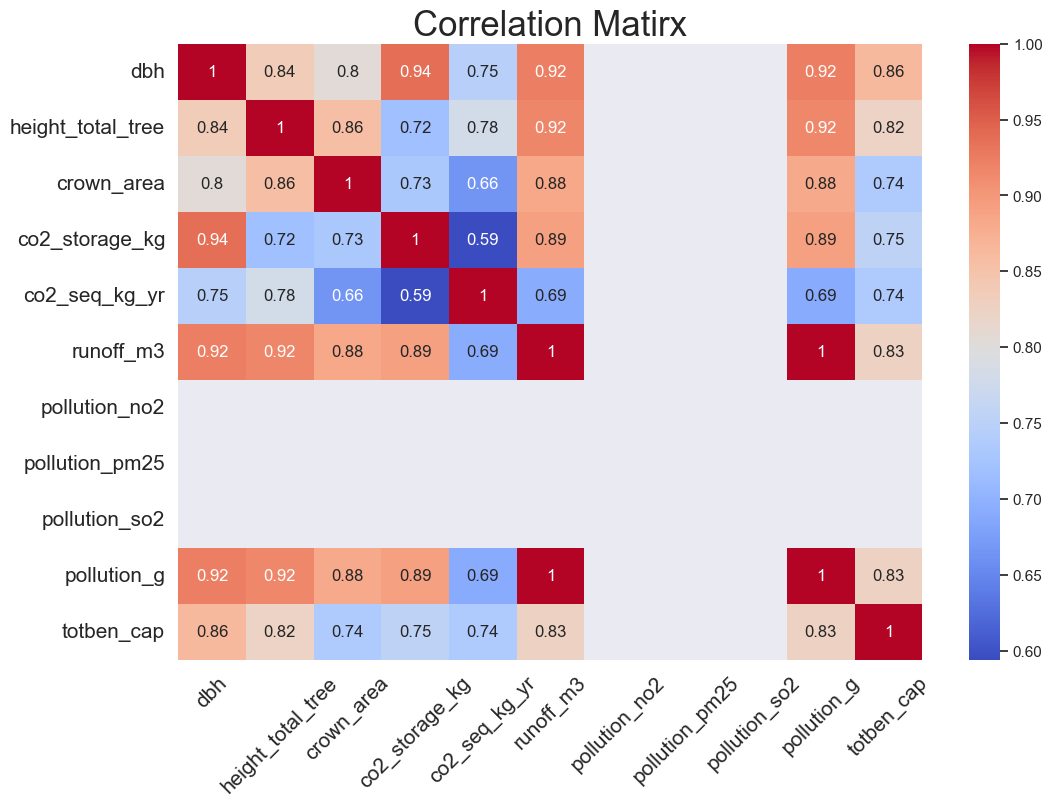

In [9]:
# drop columns with name 'id' and 'genus'
cols_float = parameters["cols_float"]

df_corr = df_ref[cols_float]
correlation_matrix = df_corr.corr()

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
ax.set_title("Correlation Matirx", fontweight="ultralight", fontsize=25)
plt.xticks(rotation=45, fontweight="ultralight", fontsize=15)
plt.yticks(fontsize=15)
plt.show()

2023-12-17 20:55:50 src.extrapolation.regressor [INFO]: Split data into training and test sets...
2023-12-17 20:55:50 src.extrapolation.regressor [INFO]: PREDICTORS: ['dbh', 'height_total_tree', 'crown_area', 'pollution_zone', 'SP_alm', 'SP_bjørk', 'SP_blodbøk', 'SP_bøk', 'SP_hestekastanje', 'SP_kulelønn', 'SP_lind', 'SP_lind_ssp', 'SP_neverhegg', 'SP_neverhegg?', 'SP_rosehagtorn', 'SP_småbladlind', 'SP_spisslønn', 'SP_svenskeasal', 'SP_søylekirsebær']
2023-12-17 20:55:50 src.extrapolation.regressor [INFO]: RESPONSE: ['totben_cap']
2023-12-17 20:55:50 src.extrapolation.regressor [INFO]: Y_train shape: (64,)
2023-12-17 20:55:50 src.extrapolation.regressor [INFO]: y_test shape: (16,)
kristiansand_totben_cap
2023-12-17 20:55:50 src.extrapolation.regressor [INFO]: Evaluate model performance on test data...
2023-12-17 20:55:50 src.extrapolation.regressor [INFO]: Model equation: y = 0.2 + 3.1*dbh + 8.4*height_total_tree + 0.1*crown_area + -1.5*pollution_zone + ...
2023-12-17 20:55:50 src.ext

<Figure size 640x480 with 0 Axes>

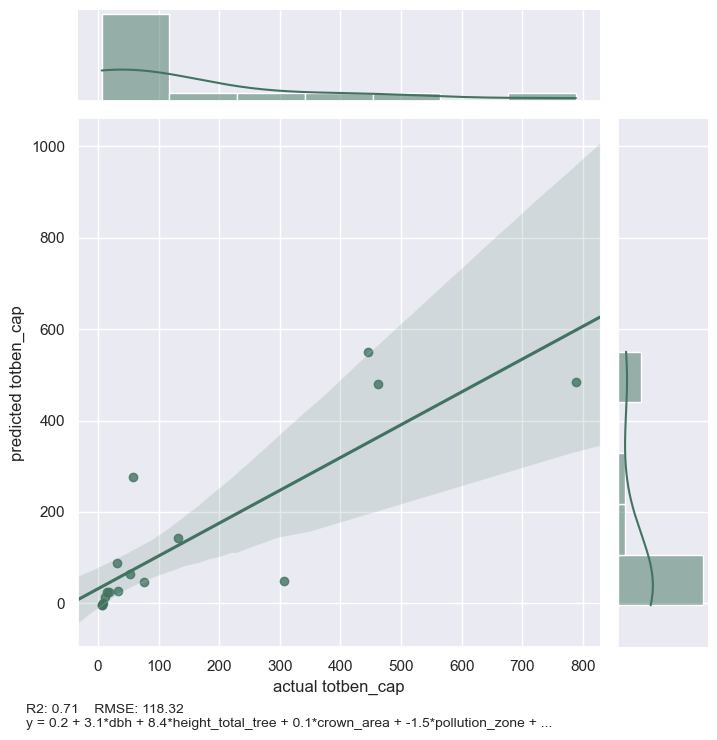

In [3]:
totben_cap(df_ref, df_target)


2023-12-17 20:55:57 src.extrapolation.regressor [INFO]: Split data into training and test sets...
2023-12-17 20:55:57 src.extrapolation.regressor [INFO]: PREDICTORS: ['height_total_tree', 'crown_area', 'pollution_zone']
2023-12-17 20:55:57 src.extrapolation.regressor [INFO]: RESPONSE: ['runoff_m3']
2023-12-17 20:55:57 src.extrapolation.regressor [INFO]: Y_train shape: (64,)
2023-12-17 20:55:57 src.extrapolation.regressor [INFO]: y_test shape: (16,)
2023-12-17 20:55:57 src.extrapolation.regressor [INFO]: Evaluate model performance on test data...
2023-12-17 20:55:57 src.extrapolation.regressor [INFO]: Model equation: y = -0.5 + 0.1*height_total_tree + 0.0*crown_area + -0.0*pollution_zone
2023-12-17 20:55:57 src.extrapolation.regressor [INFO]: R2: 0.84 	RMSE: 0.57        	MSE:0.32 	MAE: 0.36        
y = -0.5 + 0.1*height_total_tree + 0.0*crown_area + -0.0*pollution_zone
2023-12-17 20:55:57 src.extrapolation.regressor [INFO]: Plot model performance...
2023-12-17 20:55:58 src.extrapolation

<Figure size 640x480 with 0 Axes>

<Figure size 700x700 with 0 Axes>

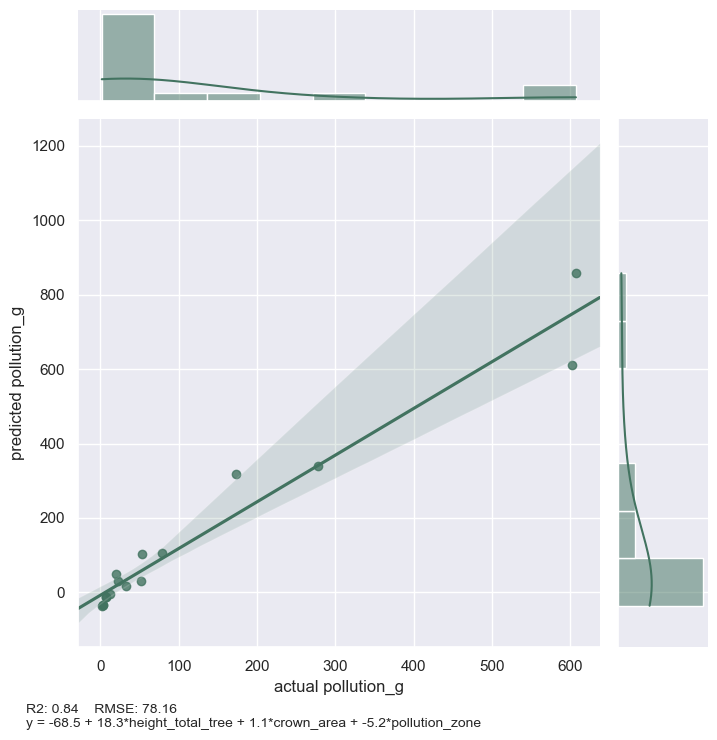

In [4]:
individual_es(df_ref, df_target)


2023-12-17 20:56:12 src.extrapolation.regressor [INFO]: Split data into training and test sets...
2023-12-17 20:56:12 src.extrapolation.regressor [INFO]: PREDICTORS: ['dbh', 'height_total_tree', 'crown_area', 'pollution_zone']
2023-12-17 20:56:12 src.extrapolation.regressor [INFO]: RESPONSE: ['co2_storage_kg']
2023-12-17 20:56:12 src.extrapolation.regressor [INFO]: Y_train shape: (64,)
2023-12-17 20:56:12 src.extrapolation.regressor [INFO]: y_test shape: (16,)
2023-12-17 20:56:12 src.extrapolation.regressor [INFO]: Evaluate model performance on test data...
2023-12-17 20:56:12 src.extrapolation.regressor [INFO]: Model equation: y = -887.4 + 54.0*dbh + -51.4*height_total_tree + 0.6*crown_area + 251.5*pollution_zone + ...
2023-12-17 20:56:12 src.extrapolation.regressor [INFO]: R2: 0.6 	RMSE: 446.91        	MSE:199732.06 	MAE: 321.19        
y = -887.4 + 54.0*dbh + -51.4*height_total_tree + 0.6*crown_area + 251.5*pollution_zone + ...
2023-12-17 20:56:12 src.extrapolation.regressor [INFO]:

<Figure size 640x480 with 0 Axes>

<Figure size 700x700 with 0 Axes>

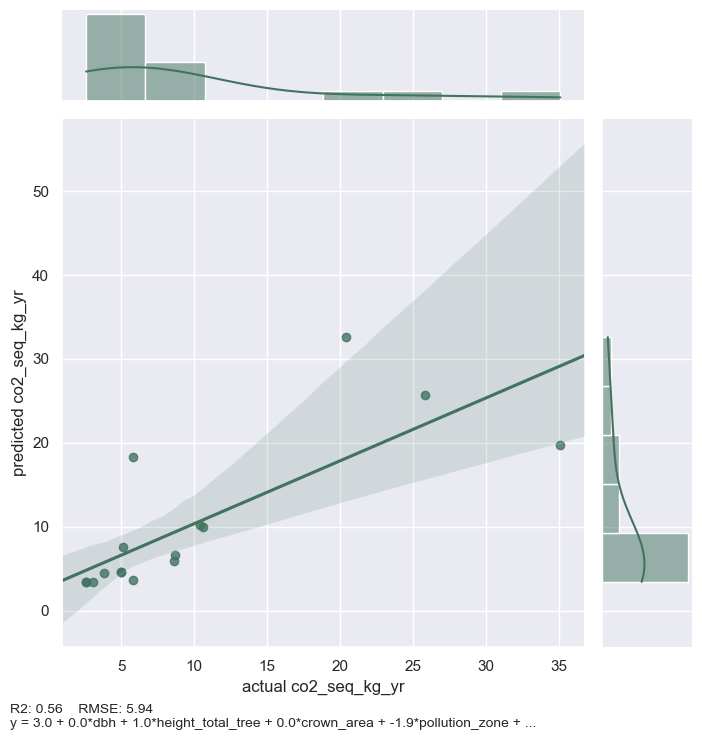

In [5]:
carbon_es(df_ref, df_target)


In [6]:
export_results()


(11081, 15)
   id norwegian_name                                species_origin  \
0   1       kulelønn  *Genus estimert basert på treslagfordelingen   
1   2     neverhegg?  *Genus estimert basert på treslagfordelingen   

   delomradenummer  grunnkretsnummer    dbh  \
0         420407.0        42040702.0   2.39   
1         420407.0        42040702.0  43.99   

                            dbh_origin  height_total_tree  \
0  dbh = (crown_diam^2.63)/(3.48^2.63)               0.53   
1  dbh = (crown_diam^2.63)/(3.48^2.63)               9.77   

                                 height_origin  crown_area  crown_diam  \
0  height_total_tree = (dbh*1.22)/(4.04**1.22)       15.87        4.85   
1  height_total_tree = (dbh*1.22)/(4.04**1.22)       68.54       14.67   

  crown_origin  pollution_zone  totben_cap  totben_cap_ca  
0    laserdata               2      -37.91            NaN  
1    laserdata               1      233.87            NaN  
(11081, 2)
   id  co2_storage_kg
0   1         -

In [7]:
summary_stat()

              dbh  height_total_tree  crown_area  totben_cap  totben_cap_ca  \
count    11081.00           11081.00    11081.00    11081.00       11081.00   
mean        30.74               6.84       64.13      136.84           1.50   
std         39.75               8.84       52.98      213.35           2.48   
min          1.40               0.31        0.79      -93.13         -11.30   
25%          8.38               1.86       29.25        6.14           0.18   
50%         17.62               3.92       47.93       75.89           1.38   
75%         37.67               8.38       81.05      192.15           2.66   
max        758.36             168.44      741.74     3823.45          25.98   
median      17.62               3.92       47.93       75.89           1.38   
sum     340637.17           75801.39   710638.67  1516287.03       16621.30   

        co2_storage_kg  co2_seq_kg_yr  runoff_m3  pollution_g  
count         11081.00       11081.00   11081.00     11081.00  
me